## Required Library

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display
import scipy.stats as stats

In [2]:
def get_page(url):
    reqs = requests.get(url)
    soup = BeautifulSoup(reqs.text, 'html.parser')
    return soup

def get_data(link):
    df = pd.read_csv(link)
    return df

def prog_bar(maks):
    f = IntProgress(min=0, max=maks) # instantiate the bar
    display(f) # display the bar
    return f

## Get Links (by year)
- Data tersedia di https://data.jakarta.go.id oleh Dinas Lingkungan Hidup
- Mencari link webpage yang berisi dataset indeks standar pencemaran udara setiap tahun dengan keyword "ISPU" + "Tahun" dari 2010 hingga 2021
- Link disimpan dalam bentuk list

In [3]:
#get yearly link
annual_link = []
for year in range(2010, 2022):
    annual_url = ('https://data.jakarta.go.id/organization/badan-pengelolaan-lingkungan-hidup-daerah?q=ISPU+'
        + str(year) + '&sort=4')
    page_annual_url = get_page(annual_url)
    for link in page_annual_url.find_all('a'):
        link = link.get('href')
        if '/dataset/' in link:
            annual_link.append(link)
            print(link)

https://data.jakarta.go.id/dataset/indeks-standar-pencemaran-udara-ispu-tahun-2010
https://data.jakarta.go.id/dataset/indeks-standar-pencemaran-udara-ispu-tahun-2011
https://data.jakarta.go.id/dataset/indeks-standar-pencemaran-udara-ispu-tahun-2012
https://data.jakarta.go.id/dataset/indeks-standar-pencemaran-udara-ispu-tahun-2013
https://data.jakarta.go.id/dataset/indeks-standar-pencemaran-udara-ispu-tahun-2014
https://data.jakarta.go.id/dataset/indeks-standar-pencemaran-udara-ispu-tahun-2015
https://data.jakarta.go.id/dataset/indeks-standar-pencemaran-udara-ispu-tahun-2016
https://data.jakarta.go.id/dataset/indeks-standar-pencemaran-udara-ispu-tahun-2017
https://data.jakarta.go.id/dataset/indeks-standar-pencemar-udara-di-provinsi-dki-jakarta-tahun-2018
https://data.jakarta.go.id/dataset/data-indeks-standar-pencemar-udara-ispu-di-provinsi-dki-jakarta-tahun-2019
https://data.jakarta.go.id/dataset/indeks-standar-pencemaran-udara-ispu-tahun-2020
https://data.jakarta.go.id/dataset/indeks-s

## Get Links (by month)
Mencari file .csv yang berisi dataset indeks standar pencemaran udara setiap bulan dalam setahun

In [4]:
#get monthly link
monthly_link = []

bar = prog_bar(len(annual_link))
for annual in annual_link:
    page_monthly = get_page(annual)
    
    for link in page_monthly.find_all('a'):
        link = link.get('href')
        if 'csv' in link and 'SPKU' in link:
            monthly_link.append(link)
            
            
    bar.value += 1 # signal to increment the progress bar

IntProgress(value=0, max=12)

## Open the File as a DataFrame
Membuka file .csv dengan pandas dataframe

In [5]:
#get all data
list_data = []
bar = prog_bar(len(monthly_link))
for links in monthly_link:
    data = get_data(links)
    list_data.append(data)
    bar.value += 1

IntProgress(value=0, max=144)

## Cleaning the Data
- Memastikan semua data hanya berisi kolom 'tanggal', 'stasiun','pm10', 'so2', 'co', 'o3','no2', 'max', 'critical', 'categori'
- Jika terdapat ketidak sesuaian perlu di cek secara manual

In [6]:
list_columns = ['tanggal', 'stasiun',
                'pm10', 'so2', 'co', 'o3',
                'no2', 'max', 'critical',
                'categori']
list_cleaned1 = []
i=0
for data in list_data:
    try:
        data = data[list_columns]
        list_cleaned1.append(data)
    except:
        list_cleaned1.append(data)
        print('please manually check index -> ' + str(i))
    i+=1

please manually check index -> 99
please manually check index -> 105
please manually check index -> 137
please manually check index -> 138


## Manual Check of Inconsistency Caused by Human Error
- Index 99 terdapat ekstra kolom "keterangan" dan kesalahan penempatan nama kolom
- index 105 terdapat kesalahan nama kolom yaitu "kategori" yang seharusnya adalah "categori"
- Index 137 dan 138 terdapat kesalahan penempatan nama kolom

In [7]:
list_cleaned1[99] = list_cleaned1[99].rename(columns={'s02':'so2','critical':'delete',
                                  'categori':'critical','keterangan':'categori'}).drop('delete', axis = 1)
list_cleaned1[105] = list_cleaned1[105].rename(columns={'kategori':'categori'})
list_cleaned1[137] = list_cleaned1[137].rename(columns={'pm10':'stasiun','pm25':'pm10','so2':'pm25', 'co':'so2',
                                  'o3':'co','no2':'o3','max':'no2','critical':'max','categori':'critical',
                                  'location':'categori'}).drop('pm25', axis = 1)
list_cleaned1[138] = list_cleaned1[138].rename(columns={'pm10':'stasiun','pm25':'pm10','so2':'pm25', 'co':'so2',
                                  'o3':'co','no2':'o3','max':'no2','critical':'max','categori':'critical',
                                  'location':'categori'}).drop('pm25', axis = 1)

In [8]:
list_cleaned1[122]['stasiun'] = list_cleaned1[120]['stasiun']

## Rechecking for Inconsistency 

In [9]:
list_cleaned2 = []
i=0
for data in list_cleaned1:
    try:
        data = data[list_columns]
        list_cleaned2.append(data)
    except:
        list_cleaned2.append(data)
        print('please manually check index -> ' + str(i))
    i+=1

## Concatenate All Data in Every Month and Year into One Dataframe

In [10]:
df = pd.concat(list_cleaned2)
df.sort_values(by=['tanggal'])

,tanggal,stasiun,pm10,so2,co,o3,no2,max,critical,categori
0,01/11/2020,DKI1 (Bunderan HI),49,67,18,10,40,11,PM25,SEDANG
120,01/11/2020,DKI5 (Kebon Jeruk) Jakarta Barat,50,22,26,45,8,50,PM10,BAIK
90,01/11/2020,DKI4 (Lubang Buaya),53,38,16,55,10,55,CO,SEDANG
60,01/11/2020,DKI3 (Jagakarsa),37,82,38,32,58,11,PM25,SEDANG
30,01/11/2020,DKI2 (Kelapa Gading),56,76,23,14,59,14,PM25,SEDANG
...,...,...,...,...,...,...,...,...,...,...
150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Remove Blank Rows

In [11]:
df = df[~df['tanggal'].isnull()]

## Make Consistent Date Format as Timestamp 

In [12]:
def date_format(date):
    sp = str(date).split('/')
    if len(sp) == 3:
        formated = '-'.join([sp[2],sp[1],sp[0]])
        return formated
    else:
        return str(date)
    
def time_stamp(date):
    formated = pd.Timestamp(date)
    return formated

df['tanggal'] = df['tanggal'].apply(date_format)
df['tanggal'] = df['tanggal'].apply(time_stamp)
df = df.sort_values(by=['tanggal','stasiun'])

## Make All Number into Countable Integer

In [13]:
df = df.replace('DKI5 (Kebon Jeruk) Jakarta Barat','DKI5 (Kebon Jeruk)')
df = df.replace('---',np.nan)
df['pm10'] = pd.to_numeric(df['pm10'])
df['so2'] = pd.to_numeric(df['so2'])
df['co'] = pd.to_numeric(df['co'])
df['o3'] = pd.to_numeric(df['o3'])
df['no2'] = pd.to_numeric(df['no2'])
df = df[['tanggal','stasiun','pm10','so2', 'co', 'o3', 'no2']]

## Function to Get Max, Critical, and Category Column

In [14]:
def get_extracol(df):
    df['max'] = df[['pm10','so2','co','o3','no2']].max(axis = 1)
    df['critical'] = df[['pm10','so2','co','o3','no2']].idxmax(axis=1)
    df['category'] = pd.cut(x=df['max'], 
                            bins=[1, 50, 100, 200, 300, np.inf],
                            labels=['Baik', 'Sedang', 'Tidak Sehat', 'Sangat Tidak Sehat', 'Berbahaya'])
    return df

## Air Pollution in Jakarta All Year

In [15]:
CompleteData = get_extracol(df.copy())
CompleteData = CompleteData[~CompleteData['category'].isnull()].reset_index(drop=True)

In [16]:
CompleteData.head()

,tanggal,stasiun,pm10,so2,co,o3,no2,max,critical,category
0,2010-01-01,DKI1 (Bunderan HI),60.0,4.0,73.0,27.0,14.0,73.0,co,Sedang
1,2010-01-02,DKI1 (Bunderan HI),32.0,2.0,16.0,33.0,9.0,33.0,o3,Baik
2,2010-01-03,DKI1 (Bunderan HI),27.0,2.0,19.0,20.0,9.0,27.0,pm10,Baik
3,2010-01-04,DKI1 (Bunderan HI),22.0,2.0,16.0,15.0,6.0,22.0,pm10,Baik
4,2010-01-05,DKI1 (Bunderan HI),25.0,2.0,17.0,15.0,8.0,25.0,pm10,Baik


Data diatas adalah data polusi di Jakarta yang direkam pada 5 lokasi pengkuran yang berbeda yaitu Bunderan HI, Kelapa Gading, Jagakarsa, Lubang Buaya, dan Kebon Jeruk. Parameter polusi yang diukur adalah particulate < 10 micron (PM 10), Sulfur Dioxide (SO2), Carbon Monoxide (CO), Nitrogen Dioxide (NO2), dan Ozone (O3). Polusi berasal dari berbagai macam sumber seperti asap kendaraan bermotor, cerobong pabrik dan lain sebagainya.

Angka indeks individu pada setiap parameter diatas adalah perhitungan dari hasil pengkuruan polusi menggunakan persamaan yang ditetapkan oleh Kementrian Lingkungan Hidup dan Kehutanan pada PERMEN NOMOR P.14/MENLHK/SETJEN/KUM.1/7/2020 tentang Indeks Pencemaran Udara

Link : https://ditppu.menlhk.go.id/portal/uploads/news/1600940556_P_14_2020_ISPU_menlhk_07302020074834.pdf

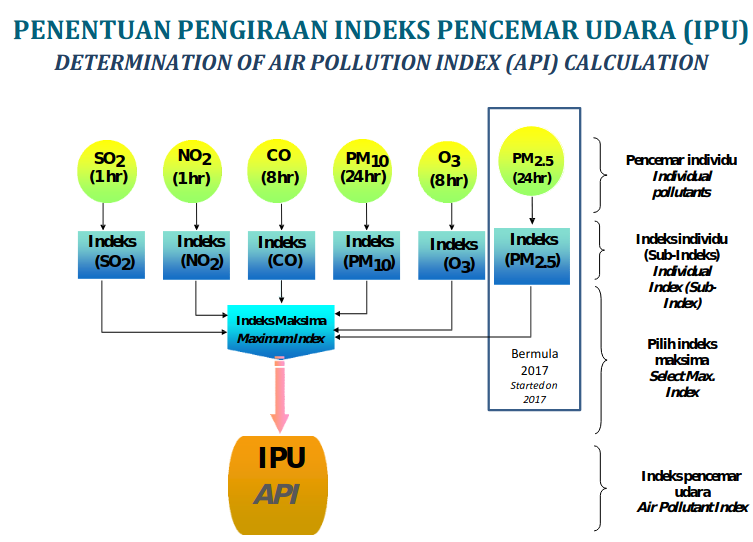

In [17]:
Image(filename='IPU.png', width = 600, height = 300)

Indeks Pencemaran Udara ditetapkan dengan mengambil indeks individu tertinggi (kolom 'max') pada setiap parameter.

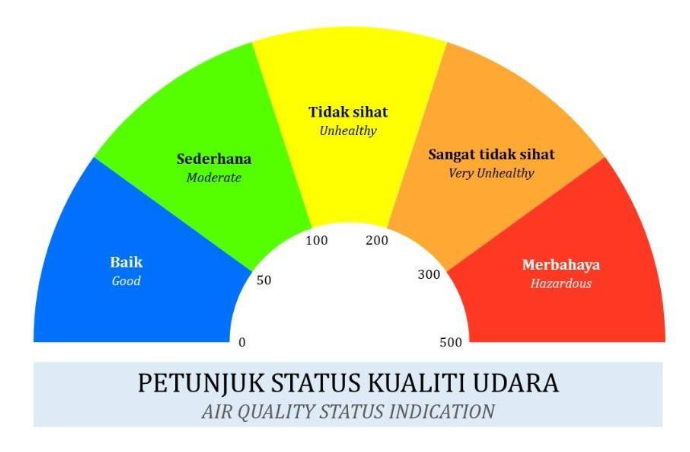

In [18]:
Image(filename='Indicator.png', width = 600, height = 300)

Gambar diatas adalah Indikasi status kualitas udara dari mulai tingkat polusi yang terbilang baik (Good : 0 - 50) hingga berbahaya (Hazardous: 300 - 500)

In [19]:
print('Descriptive Statistic Max Column:')
print(CompleteData['max'].describe().to_string(float_format="%.1f"))

Descriptive Statistic Max Column:
count   19535.0
mean       72.3
std        32.5
min         5.0
25%        53.0
50%        67.0
75%        85.0
max       314.0


Rata-rata Indeks Pencemaran Udara di Jakarta berada diangka 72.3 dan median berada di 67 yang masuk ke kategori sedang. Tingkat polusi terendah yang pernah tercatat berada di angka 5 yang masuk ke kategori Baik dan tingkat polusi tertinggi adalah 314 yang masuk ke kategori Berbahaya.

In [20]:
CategoryCount = CompleteData.category.value_counts()
CategoryPercent = CategoryCount*100/CategoryCount.sum()

print('Jumlah Setiap Kategori')
print(CategoryCount)
print('\nProporsi Setiap Kategori %')
print(CategoryPercent.to_string(float_format="%.3f"))

Jumlah Setiap Kategori
Sedang                12870
Baik                   4134
Tidak Sehat            2331
Sangat Tidak Sehat      199
Berbahaya                 1
Name: category, dtype: int64

Proporsi Setiap Kategori %
Sedang               65.882
Baik                 21.162
Tidak Sehat          11.932
Sangat Tidak Sehat    1.019
Berbahaya             0.005


Indeks Polusi di Jakarta paling sering berada di kategori Sedang (65.88%) dan Baik (21.16%), namun tidak jarang juga ada kondisi dimana polusi di Jakarta sudah masuk ke kategori Tidak Sehat (11.93%) dan Sangat Tidak Sehat (1%). Bahkan pernah satu hari dimana polusi di suatu tempat di Jakarta masuk ke level yang Berbahaya.

                      Sedang  Baik  Tidak Sehat  Sangat Tidak Sehat  Berbahaya
stasiun                                                                       
DKI1 (Bunderan HI)     69.88 26.87         3.25                0.00       0.00
DKI2 (Kelapa Gading)   63.17 17.88        15.15                3.77       0.02
DKI3 (Jagakarsa)       62.39 22.36        15.03                0.23       0.00
DKI4 (Lubang Buaya)    73.02 16.01        10.87                0.10       0.00
DKI5 (Kebon Jeruk)     59.60 22.55        16.81                1.04       0.00




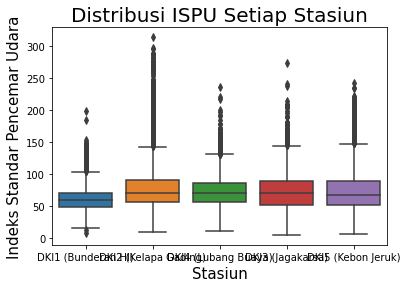

In [21]:
print(CompleteData.groupby('stasiun')['category'].value_counts().unstack().apply(lambda x: x*100/x.sum(), axis=1).to_string(float_format="%.2f"))
print('\n')
boxStationData = sns.boxplot(x="stasiun", y="max", data=CompleteData)
boxStationData.set_xlabel('Stasiun',fontsize=15)
boxStationData.set_ylabel('Indeks Standar Pencemar Udara',fontsize=15)
boxStationData.axes.set_title('Distribusi ISPU Setiap Stasiun',fontsize=20)
plt.show()

Berdasarkan data dan boxplot diatas. DKI2 Kelapa Gading merupakan daerah yang paling tidak sehat karena sering memiliki Indeks Polusi Udara yang masuk ke kategori Sangat Tidak Sehat dan Berbahaya. Sedangkan DKI1 Bunderan HI merupakan daerah paling sehat karena tidak pernah masuk ke kategori Sangat Tidak Sehat dan Berbahaya. hal ini juga terbukti pada rata-rata ISPU setiap stasiun berikut.

In [22]:
print('Rata-rata ISPU setiap stasiun')
print(CompleteData.groupby(['stasiun']).mean()['max'].to_string(float_format="%.0f"))

Rata-rata ISPU setiap stasiun
stasiun
DKI1 (Bunderan HI)     61
DKI2 (Kelapa Gading)   81
DKI3 (Jagakarsa)       73
DKI4 (Lubang Buaya)    73
DKI5 (Kebon Jeruk)     76


## Get Most Extreme Air Pollution in Jakarta All Year

In [23]:
indexExtreme = CompleteData.groupby('stasiun')['max'].idxmax()
importantcol = ['tanggal','stasiun','max','critical','category']

CompleteData.loc[indexExtreme].reset_index(drop=True)[importantcol]

,tanggal,stasiun,max,critical,category
0,2019-01-09,DKI1 (Bunderan HI),198.0,o3,Tidak Sehat
1,2012-11-04,DKI2 (Kelapa Gading),314.0,o3,Berbahaya
2,2012-10-19,DKI3 (Jagakarsa),274.0,o3,Sangat Tidak Sehat
3,2014-06-08,DKI4 (Lubang Buaya),236.0,o3,Sangat Tidak Sehat
4,2019-04-07,DKI5 (Kebon Jeruk),243.0,o3,Sangat Tidak Sehat


Tingkat polusi tertinggi pernah tercatat di Kelapa Gading pada 4 November 2012 dengan index polusi udara 314 yang masuk ke kategori Berbahaya dimana parameter yang paling kritis ada polusi gas Ozon.

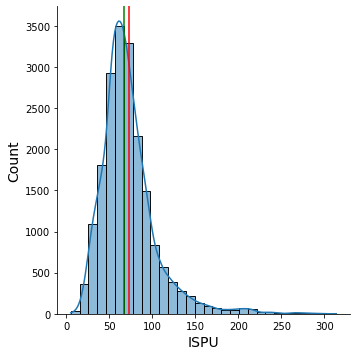

In [24]:
displotCompleteData = sns.displot(data = CompleteData, x = 'max', kde = True, bins=30)
plt.xlabel('ISPU', size=14)
plt.ylabel("Count", size=14)
plt.axvline(x=CompleteData['max'].mean(), color='red',)
plt.axvline(x=CompleteData['max'].median(), color='green')
plt.show()

Histogram diatas memiliki skewness positive yang ditandai dengan nilai median lebih kecil dibandingkan mean. Hal ini dapat terjadi karena data tersebut memiliki banyak outliers.

## Group by Date by Calculating Average data of all "Stations" in Jakarta

In [25]:
DailyData = CompleteData[['tanggal', 'stasiun','max','critical','category']].copy()
DailyData['tahun'] = pd.DatetimeIndex(DailyData['tanggal']).year
DailyData['bulan'] = pd.DatetimeIndex(DailyData['tanggal']).month
DailyData['hari'] = pd.DatetimeIndex(DailyData['tanggal']).day
DailyData['nama hari'] = pd.DatetimeIndex(DailyData['tanggal']).day_name()

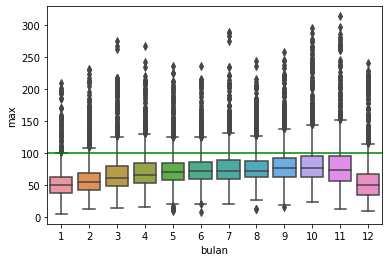

In [26]:
sns.boxplot(x="bulan", y="max",data=DailyData)
plt.axhline(y=100, color='green')
plt.show()

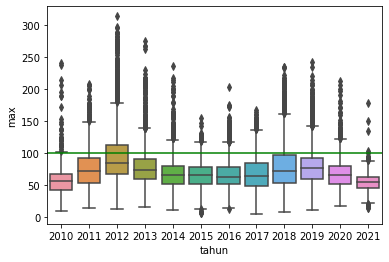

In [27]:
sns.boxplot(x="tahun", y="max",data=DailyData)
plt.axhline(y=100, color='green')
plt.show()

<AxesSubplot:xlabel='nama hari', ylabel='max'>

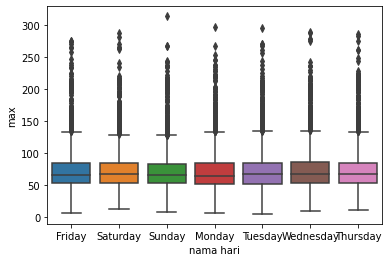

In [28]:
sns.boxplot(x="nama hari", y="max",data=DailyData)

In [29]:
DailyData.corr()

,max,tahun,bulan,hari
max,1.000000,-0.134136,0.139518,0.004360
tahun,-0.134136,1.000000,-0.027724,-0.009104
bulan,0.139518,-0.027724,1.000000,0.013011
hari,0.004360,-0.009104,0.013011,1.000000


In [30]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

new = remove_outlier(DailyData, 'max')

<AxesSubplot:xlabel='stasiun', ylabel='max'>

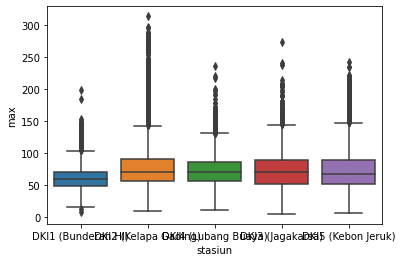

In [31]:
sns.boxplot(x="stasiun", y="max", data=DailyData)

<AxesSubplot:xlabel='tahun', ylabel='max'>

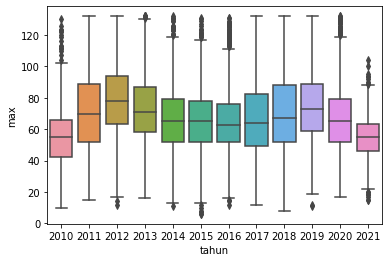

In [32]:
sns.boxplot(x="tahun", y="max",data=new)

In [33]:
def ttest(cat1, cat2):
    stat, p = stats.ttest_ind(new['max'][new['tahun'] == cat1],
                              new['max'][new['tahun'] == cat2])
    return float('%.2f' % p)

def color_cat(val):
    color = 'red' if val > 0.05 else 'white'
    return 'color: %s' % color

xx = pd.DataFrame(columns=['tahun',*range(2010,2022)])
xx = xx.set_index('tahun')

for x in range(2010,2022):
    for i in range(2010,2022):
        xx.loc[i,x] = ttest(i,x)

xx.style.applymap(color_cat)

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
tahun,,,,,,,,,,,,
2010,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
2011,0.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.510000,0.000000,0.000000,0.000000
2012,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013,0.000000,0.010000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
2014,0.000000,0.000000,0.000000,0.000000,1.000000,0.320000,0.700000,0.540000,0.000000,0.000000,0.130000,0.000000
2015,0.000000,0.000000,0.000000,0.000000,0.320000,1.000000,0.530000,0.120000,0.000000,0.000000,0.010000,0.000000
2016,0.000000,0.000000,0.000000,0.000000,0.700000,0.530000,1.000000,0.330000,0.000000,0.000000,0.060000,0.000000
2017,0.000000,0.000000,0.000000,0.000000,0.540000,0.120000,0.330000,1.000000,0.000000,0.000000,0.430000,0.000000
2018,0.000000,0.510000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


<AxesSubplot:xlabel='tahun', ylabel='max'>

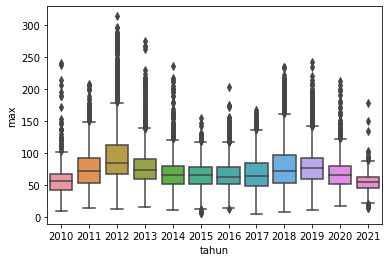

In [34]:
sns.boxplot(x="tahun", y="max",data=DailyData)

In [35]:
test = DailyData.copy()

In [37]:
def remove_outlier(data, hue):
    list_data = []
    for cat in data[hue].unique():
        val = data[data[hue] == cat]
        q1 = val['max'].quantile(0.25)
        q3 = val['max'].quantile(0.75)
        iqr = q3-q1
        fence_low  = max(val['max'].min(),q1-1.5*iqr)
        fence_high = min(val['max'].max(),q3+1.5*iqr)
        val1 = val.loc[(val['max'] > fence_low) & (val['max'] < fence_high)]
        list_data.append(val1)
    df_out = pd.concat(list_data)
    return df_out

In [42]:
test1 = remove_outlier(test, 'tahun')

<AxesSubplot:xlabel='tahun', ylabel='max'>

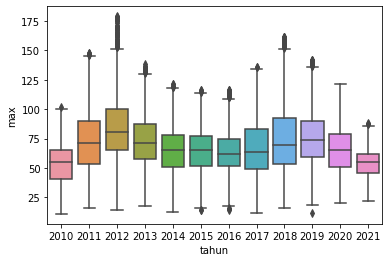

In [43]:
sns.boxplot(x="tahun", y="max",data=test1)

In [44]:
def ttest(cat1, cat2):
    stat, p = stats.ttest_ind(test1['max'][test1['tahun'] == cat1],
                              test1['max'][test1['tahun'] == cat2])
    return float('%.2f' % p)

def color_cat(val):
    color = 'red' if val > 0.05 else 'white'
    return 'color: %s' % color

xx = pd.DataFrame(columns=['tahun',*range(2010,2022)])
xx = xx.set_index('tahun')

for x in range(2010,2022):
    for i in range(2010,2022):
        xx.loc[i,x] = ttest(i,x)

xx.style.applymap(color_cat)

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
tahun,,,,,,,,,,,,
2010,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.920000
2011,0.000000,1.000000,0.000000,0.310000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
2012,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013,0.000000,0.310000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.320000,0.000000,0.000000,0.000000
2014,0.000000,0.000000,0.000000,0.000000,1.000000,0.420000,0.100000,0.090000,0.000000,0.000000,0.240000,0.000000
2015,0.000000,0.000000,0.000000,0.000000,0.420000,1.000000,0.390000,0.010000,0.000000,0.000000,0.040000,0.000000
2016,0.000000,0.000000,0.000000,0.000000,0.100000,0.390000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017,0.000000,0.000000,0.000000,0.000000,0.090000,0.010000,0.000000,1.000000,0.000000,0.000000,0.500000,0.000000
2018,0.000000,0.080000,0.000000,0.320000,0.000000,0.000000,0.000000,0.000000,1.000000,0.090000,0.000000,0.000000


In [41]:
test1

,tanggal,stasiun,max,critical,category,tahun,bulan,hari,nama hari
0,2010-01-01,DKI1 (Bunderan HI),73.0,co,Sedang,2010,1,1,Friday
7,2010-01-08,DKI1 (Bunderan HI),64.0,pm10,Sedang,2010,1,8,Friday
14,2010-01-15,DKI1 (Bunderan HI),35.0,pm10,Baik,2010,1,15,Friday
21,2010-01-22,DKI1 (Bunderan HI),51.0,pm10,Sedang,2010,1,22,Friday
28,2010-01-29,DKI1 (Bunderan HI),51.0,pm10,Sedang,2010,1,29,Friday
...,...,...,...,...,...,...,...,...,...
19525,2021-12-30,DKI1 (Bunderan HI),55.0,pm10,Sedang,2021,12,30,Thursday
19526,2021-12-30,DKI2 (Kelapa Gading),47.0,pm10,Baik,2021,12,30,Thursday
19527,2021-12-30,DKI3 (Jagakarsa),60.0,pm10,Sedang,2021,12,30,Thursday
19528,2021-12-30,DKI4 (Lubang Buaya),60.0,pm10,Sedang,2021,12,30,Thursday


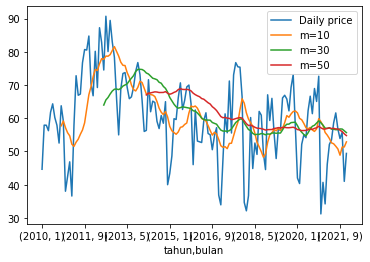

In [81]:
datas = test1[test1['stasiun'] == 'DKI1 (Bunderan HI)'].groupby(['tahun','bulan']).mean()['max']
ax = datas.plot(legend=False)
datas.rolling(window=10).mean().plot(ax=ax)
datas.rolling(window=30).mean().plot(ax=ax)
datas.rolling(window=50).mean().plot(ax=ax)
ax.legend(['Daily price', 'm=10', 'm=30', 'm=50'])

In [82]:
from statsmodels.graphics.tsaplots import plot_acf

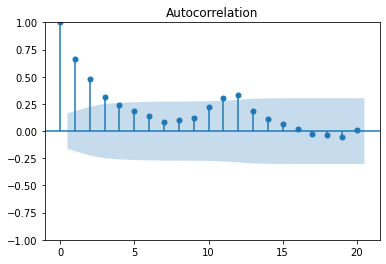

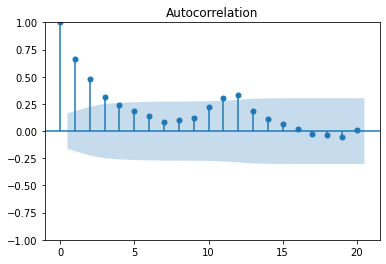

In [84]:
plot_acf(datas,lags=20)